In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.gradient_descent import SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import warnings
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
word_dict = {0:'One', 1:'Two', 2:'Three', 3:'Four', 4:'Five', 5:'Six', 6:'Seven', 7:'Eight', 8:'Nine'}

<br>

# Data Collection

In [4]:
background = None
accumulated_weight = 0.5

### Creating Dimensions for Region of Interest

In [5]:
#Creating the dimensions for the ROI...
ROI_top = 100
ROI_bottom = 350
ROI_left = 150
ROI_right = 400

### Function for Background Substraction

In [6]:
def calculate_accumulated_avg(frame, accumulated_weight):
    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None
    
    cv2.accumulateWeighted(frame, background, accumulated_weight)

### Function for Hand Segmentation and Finding contours

In [7]:
def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)
    
    _, thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    else:
        hand_segment_max_contours = max(contours, key=cv2.contourArea)
        return (thresholded, hand_segment_max_contours)

### Function for generating the Data for Signs

In [8]:
def getDataforElement(element):
    cam = cv2.VideoCapture(0)

    num_frames = 0
    nums_imgs_taken = 0

    while True:
        ret, frame = cam.read()

        frame = cv2.flip(frame, 1)
        frame_copy = frame.copy()

        roi = frame[ROI_top:ROI_bottom, ROI_left:ROI_right]

        gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

        if num_frames < 60:
            calculate_accumulated_avg(gray_frame, accumulated_weight)

            if num_frames <= 59:
                cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT", 
                            (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)

        elif num_frames <= 300:
            hand = segment_hand(gray_frame)
            cv2.putText(frame_copy, "Adjust hand...Gesture for " + str(element), 
                        (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),2)


            if hand is not None:
                thresholded, hand_segment = hand

                # Draw contours around hand segment
                cv2.drawContours(frame_copy, [hand_segment + (60, 60)], -1, (255, 0, 0),1)

                cv2.putText(frame_copy, str(num_frames)+" For " + str(element),(70, 45), cv2.FONT_HERSHEY_SIMPLEX, 
                            1, (0,0,255), 2)
                cv2.imshow("Thresholded Hand Image", thresholded)

        else:
            hand = segment_hand(gray_frame)

            if hand is not None:
                thresholded, hand_segment = hand

                cv2.drawContours(frame_copy, [hand_segment + (60, 60)], 
                                 -1, (255, 0, 0),1)
                cv2.putText(frame_copy, str(num_frames), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 
                            1, (0,0,255), 2)
                cv2.putText(frame_copy, str(nums_imgs_taken) + " images For " + str(element), 
                            (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
                cv2.imshow("Thresholded Hand Image", thresholded)


                if nums_imgs_taken <= 300:
                    cv2.imwrite(r"D:\\My Learning\\7th Semester\\Project Work - I\\Translator\\gesture\\train\\"
                                +str(element)+"\\" + str(nums_imgs_taken+300) + '.jpg', thresholded)
                    print(nums_imgs_taken, end=" ")
                else:
                    break

                nums_imgs_taken += 1

            else:
                cv2.putText(frame_copy, 'No hand detected...', (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        # Drawing ROI on frame copy
        cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,128,0), 3)

        # increment the number of frames for tracking
        num_frames += 1

        # Display the frame with segmented hand
        cv2.imshow("Sign Detection", frame_copy)

        # Closing windows with Esc key...(any other key with ord can be used too.)
        k = cv2.waitKey(1) & 0xFF
        if k == 27:
            break

    # Releasing the camera & destroying all the windows...
    cv2.destroyAllWindows()
    cam.release()

### Function for Converting the Image Data

In [9]:
def convertImage(element, threshold):
    
    nums_img_converted = 0
    
    background_path = r"D:\\My Learning\\7th Semester\\Project Work - I\\Translator\\gesture\\background.png"
    background = cv2.imread(background_path, cv2.IMREAD_UNCHANGED)
    background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
    background = cv2.GaussianBlur(background, (9,9), 0)
    
    source = r"D:\\My Learning\\7th Semester\\Project Work - I\\data\\" + str(element) + "\\"
    hand_image_path = r"D:\\My Learning\\7th Semester\\Project Work - I\\Translator\\gesture\\train\\" + str(element) + "\\"
    
    while True:
        hand_image = cv2.imread(source + str(nums_img_converted) + ".jpg")
#         hand_image = cv2.flip(hand_image, 1)
        hand_image = cv2.cvtColor(hand_image, cv2.COLOR_BGR2GRAY)

        diff = cv2.absdiff(background.astype("uint8"), hand_image)
        _, thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
        
        cv2.imwrite(hand_image_path + "R" + str(nums_img_converted) + ".jpg", thresholded)
        plt.imshow(thresholded)
        
        nums_img_converted += 1
        
        if nums_img_converted > 1199:
            break

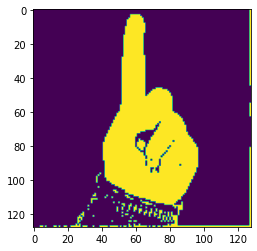

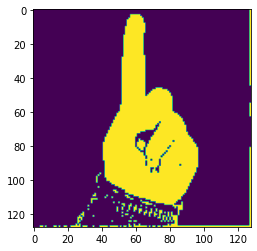

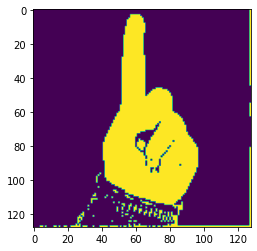

In [10]:
convertImage(1, 30)

<br>

# Training CNN

### Function to Generate Data into Batches

In [11]:
train_path = r"D:\My Learning\7th Semester\Project Work - I\Translator\gesture\train"
test_path = r"D:\My Learning\7th Semester\Project Work - I\Translator\gesture\test"

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
train_batches = train_batches.flow_from_directory(directory=train_path, target_size=(64,64), 
                                                  class_mode='categorical', batch_size=10, shuffle=True)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_batches = test_batches.flow_from_directory(directory=test_path, target_size=(64,64), 
                                                  class_mode='categorical', batch_size=10, shuffle=True)

Found 17520 images belonging to 9 classes.
Found 17520 images belonging to 9 classes.
Found 17520 images belonging to 9 classes.
Found 4320 images belonging to 9 classes.
Found 4320 images belonging to 9 classes.
Found 4320 images belonging to 9 classes.


In [12]:
# Function to plot images on the console
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()

    for img, ax in zip(images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()
        

# Function to get Image Data from batches
def getImageData(batches):
    imgs, labels = next(batches)

    plotImages(imgs)
    print(imgs.shape)
    print(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

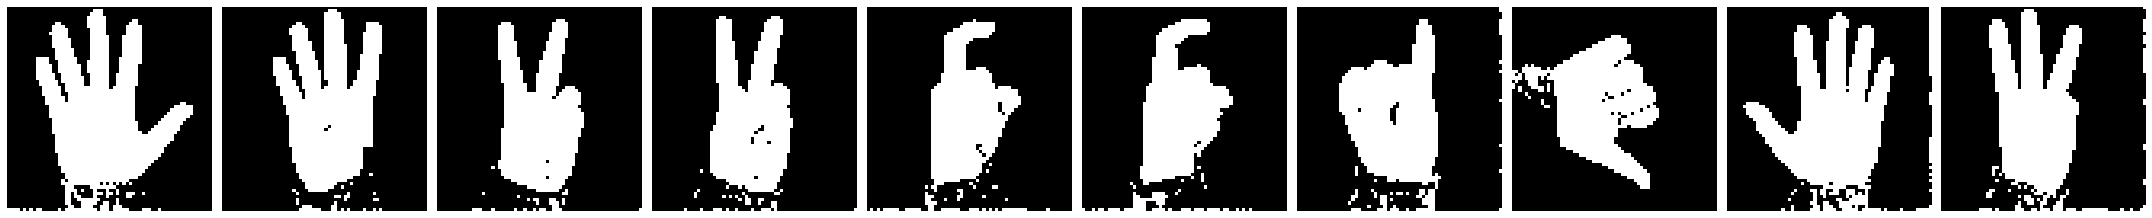

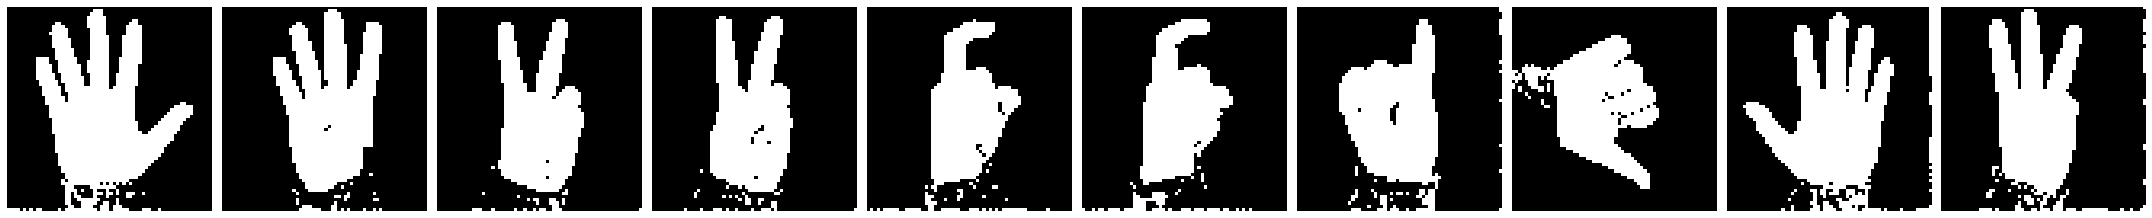

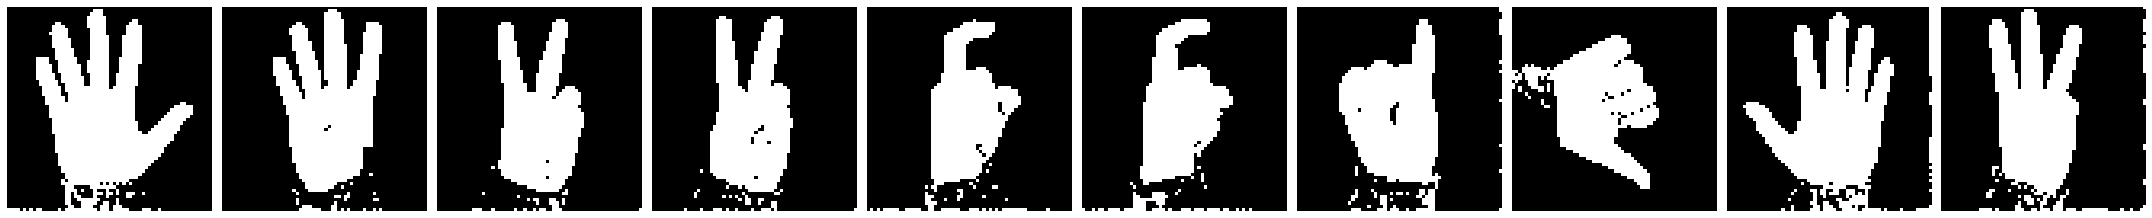

(10, 64, 64, 3)
[[0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]]
(10, 64, 64, 3)
[[0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]]
(10, 64, 64, 3)
[[0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

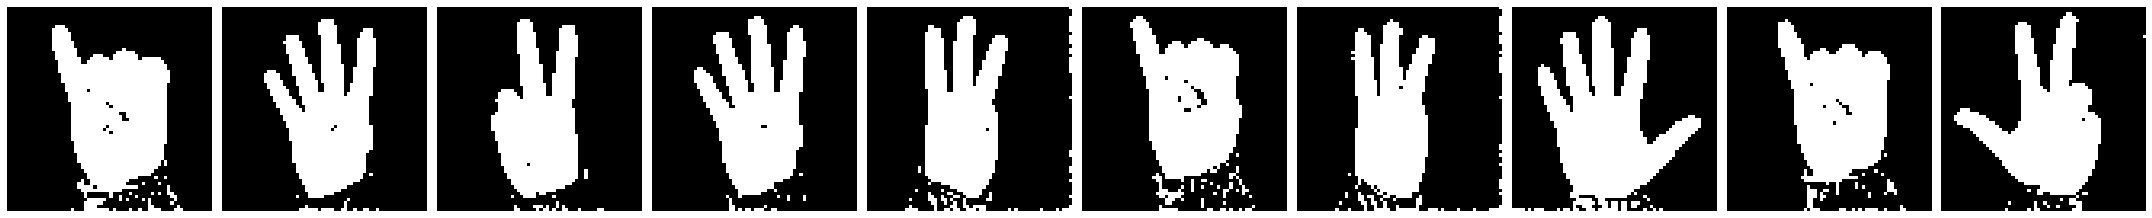

(10, 64, 64, 3)
[[0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]


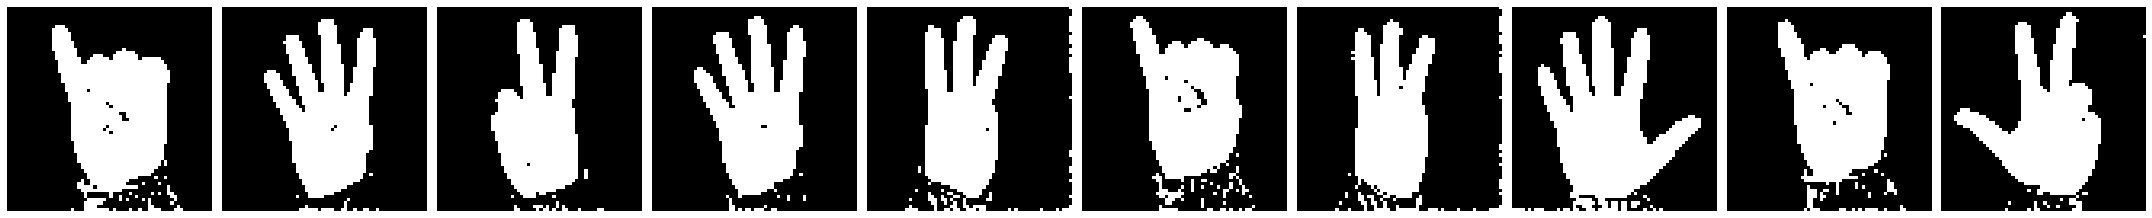

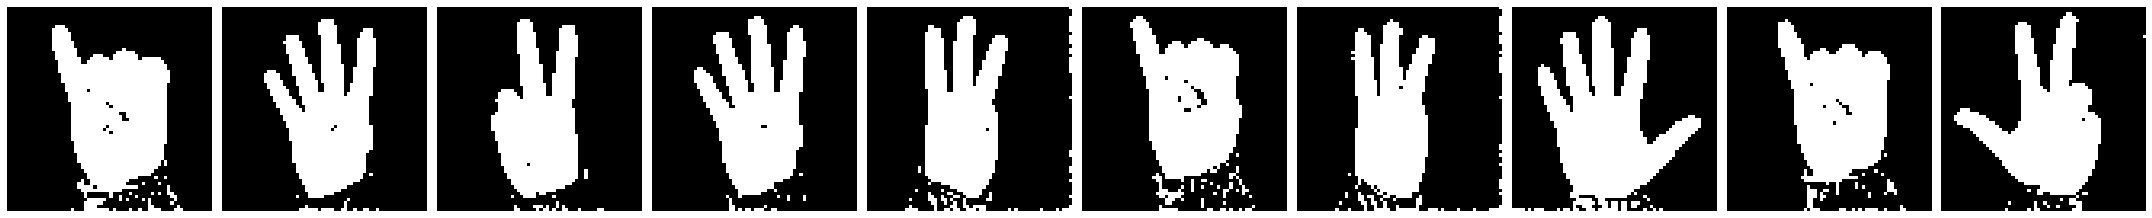

(10, 64, 64, 3)
[[0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(10, 64, 64, 3)
[[0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [13]:
getImageData(train_batches)
getImageData(test_batches)

### Creating CNN Layers

In [14]:
model = Sequential()

# 1st Convolution Layer
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd Convolution Layer
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3rd Convolution Layer          
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4th Convolution Layer          
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


# Flattening
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))


# 2nd Fully Connected Layer
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))


# 3rd Fully Connected Layer
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))


model.add(Dense(9, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)  

                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 8, 8, 128)         0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 128)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 8, 8, 128)         0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                             
          

Total params: 400,649
Total params: 400,649
Total params: 400,649
Trainable params: 399,305
Trainable params: 399,305
Trainable params: 399,305
Non-trainable params: 1,344
Non-trainable params: 1,344
Non-trainable params: 1,344
_________________________________________________________________
_________________________________________________________________
_________________________________________________________________


### Using ADAM Optimizer

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

### Using SGD Optimizer

In [17]:
# model.compile(optimizer=SGD(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [18]:
history = model.fit(train_batches, epochs=10, callbacks=[reduce_lr, early_stop], validation_data=test_batches)

Epoch 1/10
Epoch 1/10
Epoch 1/10
1752/1752 [==============================] - 1253s 711ms/step - loss: 1.2862 - accuracy: 0.5616 - val_loss: 1.6608 - val_accuracy: 0.4280 - lr: 1.0000e-04
Epoch 2/10
Epoch 2/10
Epoch 2/10
1752/1752 [==============================] - 399s 228ms/step - loss: 0.3313 - accuracy: 0.9115 - val_loss: 1.4283 - val_accuracy: 0.6442 - lr: 1.0000e-04
Epoch 3/10
Epoch 3/10
Epoch 3/10
1752/1752 [==============================] - 416s 237ms/step - loss: 0.1611 - accuracy: 0.9595 - val_loss: 0.7895 - val_accuracy: 0.7183 - lr: 1.0000e-04
Epoch 4/10
Epoch 4/10
Epoch 4/10
1752/1752 [==============================] - 889s 508ms/step - loss: 0.1045 - accuracy: 0.9730 - val_loss: 0.2978 - val_accuracy: 0.8963 - lr: 1.0000e-04
Epoch 5/10
Epoch 5/10
1752/1752 [==============================] - 264s 151ms/step - loss: 0.0784 - accuracy: 0.9806 - val_loss: 0.1614 - val_accuracy: 0.9275 - lr: 1.0000e-04
Epoch 6/10
Epoch 6/10
1752/1752 [==============================] - 282s 161

In [19]:
print("Loss :", history.history['loss'])
print("Accuracy :", history.history['accuracy'])
print("Val Loss :", history.history['val_loss'])
print("Val Accuracy :", history.history['val_accuracy'])
print("LR :", history.history['lr'])

Loss : [1.286153793334961, 0.33125415444374084, 0.16111953556537628, 0.10448174178600311, 0.0783701241016388, 0.049422044306993484, 0.04057156667113304, 0.03539859503507614, 0.029335997998714447, 0.026528427377343178]
Accuracy : [0.5616438388824463, 0.9114726185798645, 0.9595319628715515, 0.9730022549629211, 0.9805936217308044, 0.986872136592865, 0.9903538823127747, 0.9912671446800232, 0.9922374486923218, 0.9925799369812012]
Val Loss : [1.6608424186706543, 1.4282985925674438, 0.7894979119300842, 0.29777035117149353, 0.16141051054000854, 0.10342969745397568, 0.07752778381109238, 0.013980369083583355, 0.004660699050873518, 0.005221517290920019]
Val Accuracy : [0.4280092716217041, 0.6442129611968994, 0.7182870507240295, 0.8962963223457336, 0.9275463223457336, 0.9583333134651184, 0.9696758985519409, 0.9946759343147278, 0.998379647731781, 0.9986110925674438]
LR : [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04]
Loss : [1.286153793334961, 0.33125415444374084, 0.16111953

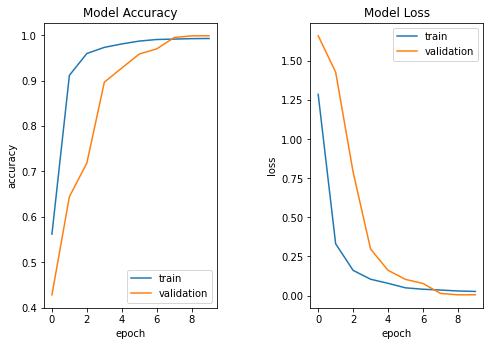

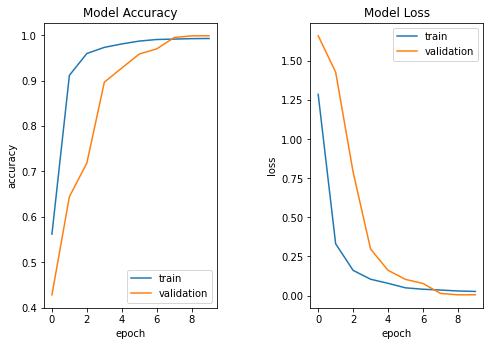

In [20]:
# Plotting Model Accuracy for both Training and Validation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title("Model Accuracy")
ax1.set_xlabel("epoch")
ax1.set_ylabel("accuracy")
ax1.legend(['train', 'validation'], loc="lower right")

# Plotting Model Loss for both Training and Validation
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title("Model Loss")
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.legend(['train', 'validation'], loc="upper right")

fig.tight_layout(pad=5.0)
plt.show()

In [21]:
imgs, labels = next(test_batches) 
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

model.save("Sign_Language_Translator_ADAM.h5")

loss of 0.0006931663956493139; accuracy of 100.0%
loss of 0.0006931663956493139; accuracy of 100.0%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

predictions on a small set of test data--

Eight   Five   One   Nine   Three   Seven   Seven   Eight   Nine   Eight   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predictions on a small set of test data--

Eight   Five   One   Nine   Three   Seven   Seven   Eight   Nine   Eight   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


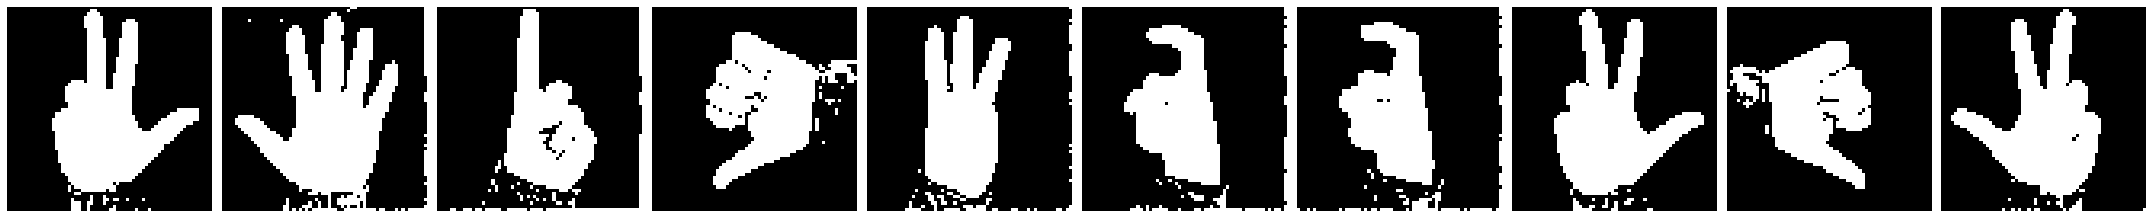

Actual labels
Eight   Five   One   Nine   Three   Seven   Seven   Eight   Nine   Eight   

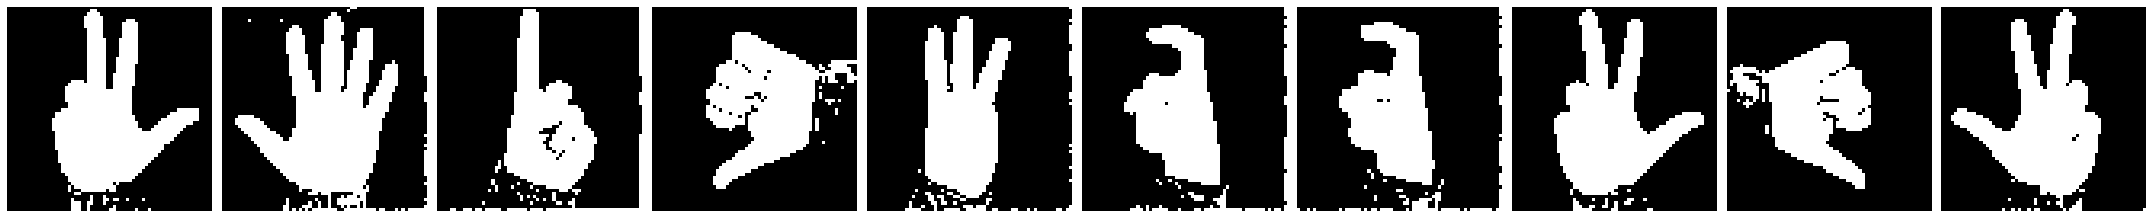

Actual labels
Eight   Five   One   Nine   Three   Seven   Seven   Eight   Nine   Eight   

In [22]:
predictions = model.predict(imgs, verbose=0)

print("predictions on a small set of test data--")
print("")

for ind, i in enumerate(predictions):
    print(word_dict[np.argmax(i)], end='   ')
    
plotImages(imgs)

print('Actual labels')
for i in labels:
    print(word_dict[np.argmax(i)], end='   ')

<br>

In [23]:
= model = keras.models.load_model("Sign_Language_Translator_ADAM.h5")

SyntaxError: invalid syntax (<ipython-input-23-5291a349976b>, line 1)

SyntaxError: invalid syntax (<ipython-input-23-5291a349976b>, line 1)

# Predict the Gesture

In [ ]:
import time

def predict_gesture():
    cam = cv2.VideoCapture(0)
    num_frames = 0

    while True:
        ret, frame = cam.read()

        frame = cv2.flip(frame, 1)
        frame_copy = frame.copy()

        roi = frame[ROI_top:ROI_bottom, ROI_left:ROI_right]

        gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

        if num_frames < 70:
            calculate_accumulated_avg(gray_frame, accumulated_weight)

            cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT", 
                        (120, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)

        else:
            hand = segment_hand(gray_frame)

            if hand is not None:
                thresholded, hand_segment = hand

                # Draw contours around hand segment
#                 cv2.drawContours(frame_copy, [hand_segment + (0, 60)], -1, (255, 0, 0),1)
                cv2.imshow("Thresholded Hand Image", thresholded)
                
                thresholded = cv2.resize(thresholded, (64, 64))
                thresholded = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB)
                thresholded = np.reshape(thresholded, (1, thresholded.shape[0], thresholded.shape[1], 3))
                
                pred = model.predict(thresholded)
                
                cv2.putText(frame_copy, word_dict[np.argmax(pred)],
                            (170, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            else:
                cv2.putText(frame_copy, 'No hand detected...', (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)

                
        # Drawing ROI on frame copy
        cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,128,0), 3)

        # increment the number of frames for tracking
        num_frames += 1

        # Display the frame with segmented hand
        cv2.imshow("Sign Detection", frame_copy)

        # Closing windows with Esc key...(any other key with ord can be used too.)
        k = cv2.waitKey(1) & 0xFF
        if k == 27:
            break

    # Releasing the camera & destroying all the windows...
    cv2.destroyAllWindows()
    cam.release()

In [ ]:
predict_gesture()